## MLP Model:

In [1]:
## import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# load in the final data set
df = pd.read_csv('../data/cleaned_data/FINAL_DATA.csv')

# create new grading variables
### get total score
### classify coffees by total score
df['total_score'] = df['Aroma'] + df['Flavor'] + df['Aftertaste'] + df['Acidity'] + df['Body'] + df['Balance'] + df['Uniformity'] + df['Clean.Cup'] + df['Sweetness']
df['market_grade'] = pd.cut(df['total_score'], bins = [0, 75, 78, 90],
                            labels = ['Normal', 'Premium', 'Specialty'])

print(df['market_grade'].value_counts())

market_grade
Premium      253
Normal       101
Specialty     48
Name: count, dtype: int64


<Axes: xlabel='total_score', ylabel='Count'>

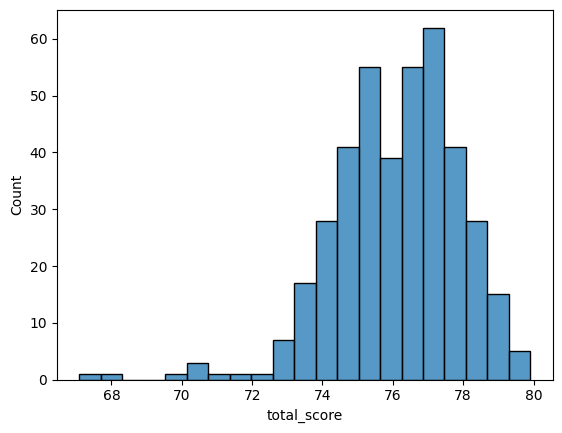

In [ ]:
## displayed distribution of total scores
### SCAA grading is a little bit subjective, so thresholds can be based
### off of the distribution
sns.histplot(df['total_score'])

In [ ]:
# separate the data into explanatory and response variables
### DO NOT include any variables used to calculate total score
X = df[['Country.of.Origin', 'Number.of.Bags', 'Bag.Weight', 'Harvest.Year',
        'Processing.Method', 'Moisture', 'Category.One.Defects', 'Quakers',
        'Color', 'Category.Two.Defects', 'Species', 'Altitude']]
y = df['market_grade']

# separate data into train-test sets
# make sure random state is set to be constant
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    shuffle = True,
                                                    random_state = 6021)

# select all of the numeric column names and categorical column names
numeric_columns = X.select_dtypes(include = ['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include = ['object']).columns

# build the preprocesser that standardizes the numeric columns
# and one hot encodes the categorical columns
### standardization is needed for mlp models
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_columns), # this is z-score standardization
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"),
         categorical_columns)
    ]
)

# fit preprocesser on X_train and X_test
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# convert the y variables in numerics and assign labels
# to them so we know what level each number corresponds to
labeler = LabelEncoder()
y_train_encoded = labeler.fit_transform(y_train)
y_test_encoded = labeler.transform(y_test)

### MLP Model 1: Simple


*   Dense Layer --> ReLU function & regularization
*   Dropout of 0.3 (in order to prevent overfitting)
*   No hidden layers
*   Dense Layer --> softmax function
*   NO hidden layers
*   tested different learning rates, batch sizes, epochs, and patience and this is the best model for this specific architecture

Given that the data set is not that large and there are only 3 levels of the response variable, it was important to test a smaller model to see if overfitting was a problem.





In [ ]:
# make sure to set seeds for reproducibility
seed = 6021
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# compute the class weights because the dataset is so imbalanced
### ensures that the model will not predict the most popular class
cw = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(cw))

# messed with different learning rates, batch sizes, epochs, patiences,
# and l2 regularization

### this is BEST combination for the simpler model
learning_rate = 0.001
batch_size = 32
num_hidden = 32
num_classes = len(np.unique(y_train_encoded))

# define the model layers
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
])

# define the model learning rate and what loss curve will look at
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# define criteria for early stopping when using the loss curve
early_stop = callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor='val_loss'
)

# compile all of the model criteria
history = model.fit(
    X_train_processed,
    y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1,
    class_weight = class_weight
)

test_loss, test_acc = model.evaluate(X_test_processed, y_test_encoded)
print(test_acc)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4910 - loss: 1.4581 - val_accuracy: 0.5538 - val_loss: 1.0093
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5194 - loss: 1.3573 - val_accuracy: 0.5692 - val_loss: 1.0066
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4433 - loss: 1.4280 - val_accuracy: 0.5692 - val_loss: 1.0041
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5010 - loss: 1.2981 - val_accuracy: 0.5692 - val_loss: 1.0026
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5018 - loss: 1.2838 - val_accuracy: 0.5692 - val_loss: 1.0024
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4821 - loss: 1.2603 - val_accuracy: 0.5692 - val_loss: 1.0030
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4716 - loss: 1.3079 - val_accuracy: 0.5846 - val_loss: 1.0040
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4954 - loss: 1.2654 - val_accuracy: 0.5692 - val_loss: 1.0048

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


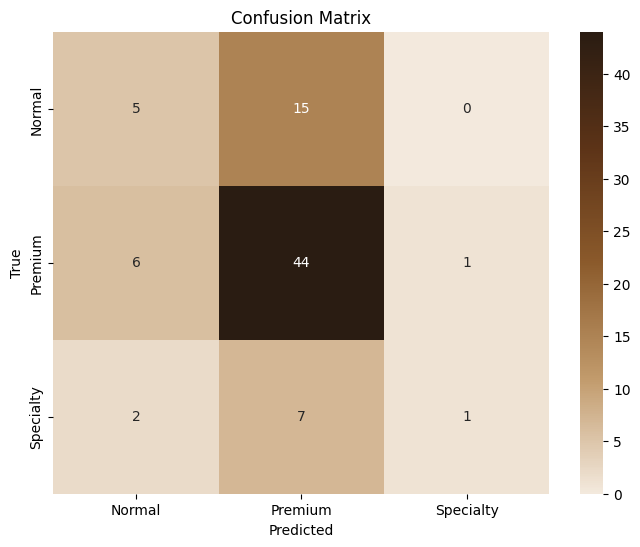

              precision    recall  f1-score   support

      Normal       0.38      0.25      0.30        20
     Premium       0.67      0.86      0.75        51
   Specialty       0.50      0.10      0.17        10

    accuracy                           0.62        81
   macro avg       0.52      0.40      0.41        81
weighted avg       0.58      0.62      0.57        81



In [ ]:
# use testing set to get model prediction probabilities
y_pred_probs = model.predict(X_test_processed)

# assign classes based on probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# relabel the test set and prediction to have the names instead of numbers
y_pred_labels = labeler.inverse_transform(y_pred_classes)
y_true_labels = labeler.inverse_transform(y_test_encoded)

# define custom coffee colormap
brown_cmap = LinearSegmentedColormap.from_list(
    "brown_gradient",
    ["#f3e9dd", "#c19a6b", "#8b5a2b", "#5c3317", "#2a1c12"]
)

# create and plot a confucian matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labeler.classes_,)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=brown_cmap, xticklabels=labeler.classes_, yticklabels=labeler.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_labels, y_pred_labels, target_names=labeler.classes_))

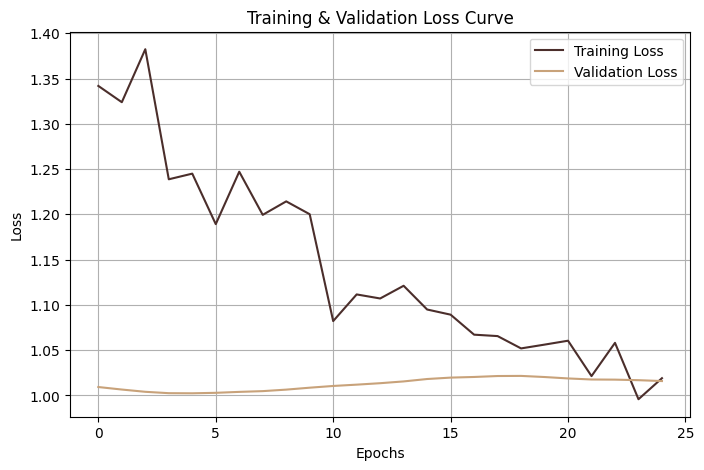

In [ ]:
# get the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the training and validation loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss', color='#4B2E2B')
plt.plot(val_loss, label='Validation Loss', color='#C8A27A')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


### MLP Model 2: Complicated

*   Set of 3 layers that are repeated 3 times in the model with different number of neurons (decreases for each new iteration)
    *   Dense Layer --> ReLU function & NO regularization
    *   Batch Normalization layer
    *   Dropout of 0.3 (in order to prevent overfitting)
*   No hidden layers (they just seem to make model worse)
*   Dense Layer --> softmax function
*   tested different learning rates, batch sizes, epochs, and patience and this is the best model for this specific architecture

Given that the data set has many categorical variables with many levels, I thought capturing the nuance could require more layers and different architecture in order to accurately predict market grade





In [ ]:
# make sure to set seeds for reproducibility
seed = 6021
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# compute the class weights because the dataset is so imbalanced
### ensures that the model will not predict the most popular class
cw = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(cw))


# messed with different learning rates, batch sizes, epochs, patiences,
# and l2 regularization

### this is BEST combination for the simpler model
learning_rate = 0.0005
batch_size = 64
num_hidden = 32
num_classes = len(np.unique(y_train_encoded))

# define the model layers
model2 = keras.Sequential([
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    #layers.Dense(num_hidden, activation = 'relu'),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    #layers.Dense(num_hidden, activation = 'relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
   # layers.Dense(num_hidden, activation = 'relu'),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')
])

# define the model learning rate and what loss curve will look at
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# define criteria for early stopping when using the loss curve
early_stop = callbacks.EarlyStopping(
    patience=40,
    restore_best_weights=True,
    monitor='val_loss'
)

# compile all of the model criteria
history = model2.fit(
    X_train_processed,
    y_train_encoded,
    validation_split=0.2,
    epochs=300,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1,
    class_weight = class_weight
)

test_loss, test_acc = model2.evaluate(X_test_processed, y_test_encoded)
print(test_acc)


Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.1979 - loss: 1.9674 - val_accuracy: 0.3692 - val_loss: 1.0845
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1917 - loss: 1.7861 - val_accuracy: 0.4154 - val_loss: 1.0709
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2161 - loss: 1.5868 - val_accuracy: 0.5231 - val_loss: 1.0620
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2911 - loss: 1.4736 - val_accuracy: 0.5077 - val_loss: 1.0528
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3198 - loss: 1.3741 - val_accuracy: 0.5385 - val_loss: 1.0451
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3516 - loss: 1.3450 - val_accuracy: 0.5538 - val_loss: 1.0378
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3552 - loss: 1.2088 - val_accuracy: 0.5692 - val_loss: 1.0303
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3260 - loss: 1.3311 - val_accuracy: 0.5538 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


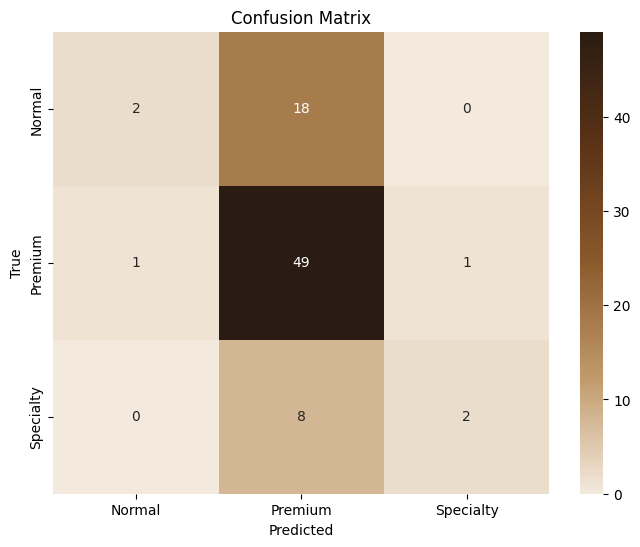

              precision    recall  f1-score   support

      Normal       0.67      0.10      0.17        20
     Premium       0.65      0.96      0.78        51
   Specialty       0.67      0.20      0.31        10

    accuracy                           0.65        81
   macro avg       0.66      0.42      0.42        81
weighted avg       0.66      0.65      0.57        81



In [ ]:
# use testing set to get model prediction probabilities
y_pred_probs = model2.predict(X_test_processed)

# assign classes based on probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# relabel the test set and prediction to have the names instead of numbers
y_pred_labels = labeler.inverse_transform(y_pred_classes)
y_true_labels = labeler.inverse_transform(y_test_encoded)

# define custom coffee colormap
brown_cmap = LinearSegmentedColormap.from_list(
    "brown_gradient",
    ["#f3e9dd", "#c19a6b", "#8b5a2b", "#5c3317", "#2a1c12"]
)

# create and plot a confucian matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labeler.classes_,)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=brown_cmap, xticklabels=labeler.classes_, yticklabels=labeler.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_labels, y_pred_labels, target_names=labeler.classes_))


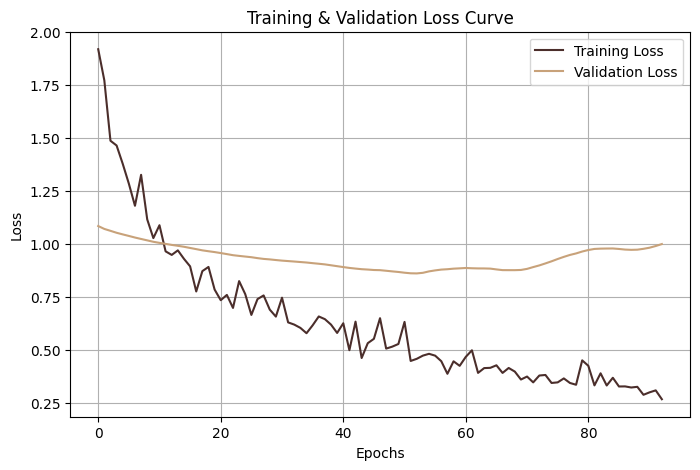

In [ ]:
# get the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the training and validation loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss', color='#4B2E2B')
plt.plot(val_loss, label='Validation Loss', color='#C8A27A')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### Final Notes:

It looks like both models do not perform the greatest in terms of predicting the levels of market grade based on farming and physical attributes. The more complicated model does not do a good job of predicting any other class except Premium (the most popular level in the dataset). As a result, the accuracy is higher, but it misses key information about the other two kinds of coffee (normal and specialty). The simpler model does have a comparable accuracy (although a tiny bit smaller). However, this model 'spreads' out its predictions, meaning it likely has captured more nuance for each kind of coffee bean at the expense of being more accurate.

In general, both of these models do not perform the greatest. They both are quite bad as the accuracies are low. This could be a result of a limited data set. Most neural networks tend to work on larger datasets as they need more data to create the different connections and determine the weights between layers and our data set is qutie limited. Another potential reason that these models are especially bad is because coffee data as a whole might be harder to predict. Since these scores are subjective and rely upon human identification of defects, there is a lot of potential for error (making it harder to analyze and predict).